In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.api
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import math

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#russia dataset

In [3]:
xls = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')
df_russia = pd.read_excel(xls, 'Russia - Sberbank Rossii PAO (S')
#df2 = pd.read_excel(xls, 'Sheet2')

In [4]:
df_russia.shape

(312, 7)

In [5]:
df_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [6]:
#Rename the Vol. column to Volume
df_russia.rename(columns = {'Vol.': 'Volume'}, inplace = True)

In [7]:
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Volume    311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB


In [8]:
df_russia.tail()

,Date,Price,Open,High,Low,Volume,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [9]:
#drop the last row
df_russia.drop(index=df_russia.index[-1], axis=0, inplace=True)
df_russia["Volume"]=df_russia.Volume.str.replace('M','')

In [10]:
df_russia.tail()

,Date,Price,Open,High,Low,Volume,Change %
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85,0.0008
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85,0.0010


In [11]:
df_russia["Date"]=pd.to_datetime(df_russia.Date,format="%Y-%m-%d")

In [12]:
df_russia=df_russia.astype({'Price':'float','Open':'float','High':'float','Low':'float','Volume':'float'})
print(df_russia.dtypes)

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Volume             float64
Change %           float64
dtype: object


In [13]:
df_russia.describe()

,Price,Open,High,Low,Volume,Change %
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141,73.056977,0.000668
std,32.079847,32.058167,32.075624,32.076603,38.058095,0.021931
min,174.270000,175.000000,182.200000,172.150000,8.760000,-0.095700
25%,207.700000,207.215000,209.660000,204.475000,47.670000,-0.010100
50%,229.140000,229.080000,231.950000,226.860000,66.260000,0.000400
75%,264.380000,263.885000,267.255000,261.110000,85.120000,0.012950
max,293.300000,294.860000,296.070000,291.500000,263.040000,0.129000


In [14]:
df_russia.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

In [15]:
#As we can see, there is no missing values. The highest close price over the discussed time is 293.3 and the lowest value is 291.5

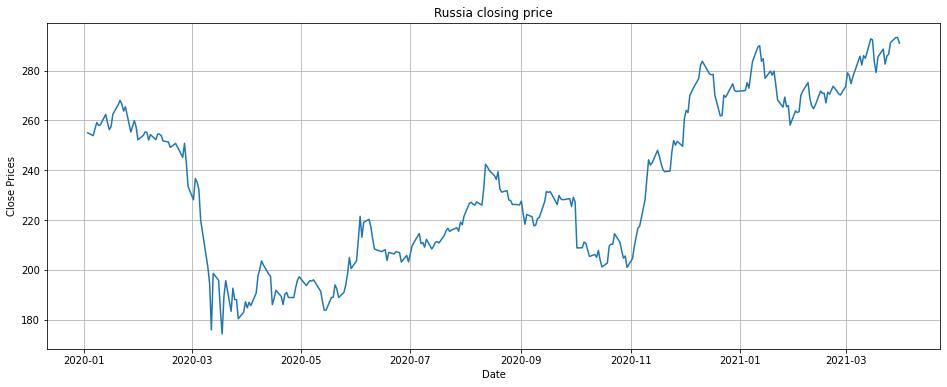

In [16]:
plt.figure(figsize=(16,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_russia['Date'],df_russia['Price'])
plt.title('Russia closing price')
plt.show()

In [17]:
df_russia.head()

,Date,Price,Open,High,Low,Volume,Change %
0,2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076
1,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002
2,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
4,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030


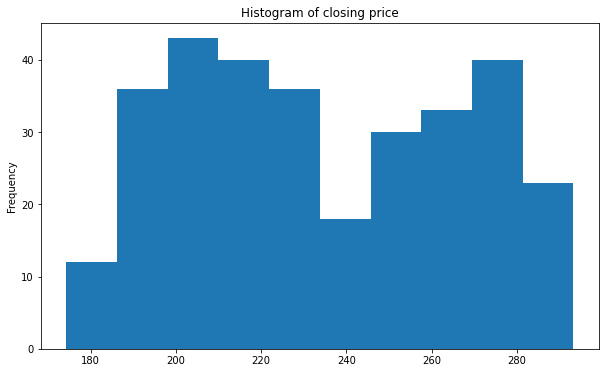

In [18]:
plt.figure(figsize=(10,6))
df_close = df_russia['Price']
df_close.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

Testing For Stationarity:

To identify the nature of the data, we will be using the null hypothesis.

#Ho: It is non-stationary
#H1: It is stationary
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

In [19]:
df_cpy =df_russia.copy()

In [20]:
#drop Open, Low, High, year and month columns
#df_russia=df_russia.drop(['Open','Low','High'],axis=1)
df_russia.set_index("Date", inplace = True)
df_russia.head()


,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030


rolling_mean: Date
2021-03-31           NaN
2021-03-30           NaN
2021-03-29           NaN
2021-03-26           NaN
2021-03-25           NaN
2021-03-24           NaN
2021-03-23    289.120000
2021-03-22    288.781429
2021-03-19    287.670000
Name: Price, dtype: float64 

rolling_std: Date
2021-03-31         NaN
2021-03-30         NaN
2021-03-29         NaN
2021-03-26         NaN
2021-03-25         NaN
2021-03-24         NaN
2021-03-23    4.127150
2021-03-22    4.041631
2021-03-19    3.659672
Name: Price, dtype: float64


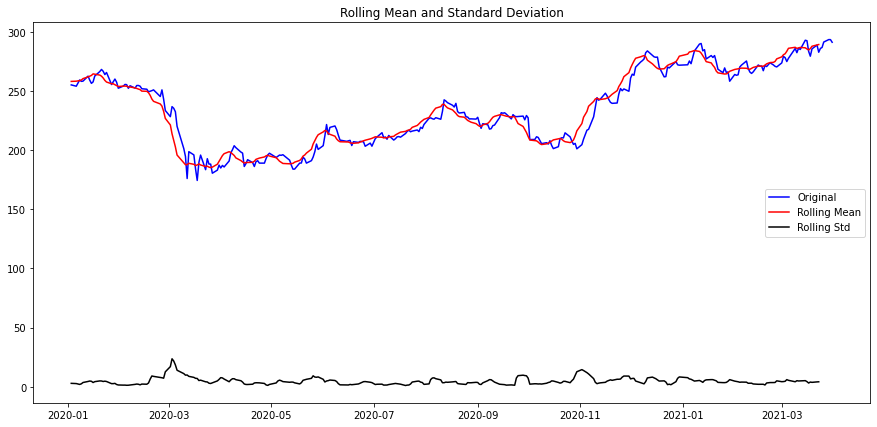

Results of dickey fuller test
Test Statistics                 -1.847182
p-value                          0.357301
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [21]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    print('rolling_mean:', rolmean.head(9),'\n')
    print('rolling_std:', rolstd.head(9))
    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_russia['Price'])


In [22]:
#We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis - that the time series is non-stationary and does have time-dependent structure. Also, the test statistics is greater than the critical values. so the data is non-stationary and does have time-dependent structure.

In [23]:
#From non stationary to stationary series
#One method for transforming the simplest non-stationary data is differencing. 
#This process involves taking the differences of consecutive observations.
#For simple distributions, taking the first-order difference.

In [24]:
df_russia["diff_1"] = df_russia.Price.diff(periods=1)
df_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,NaN
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56


In [25]:
results = adfuller(df_russia["diff_1"].dropna())
print('The new p-value is:',results[1])

The new p-value is: 4.3951775754216564e-07


<AxesSubplot:title={'center':'The distribution of the new series'}, xlabel='Date'>

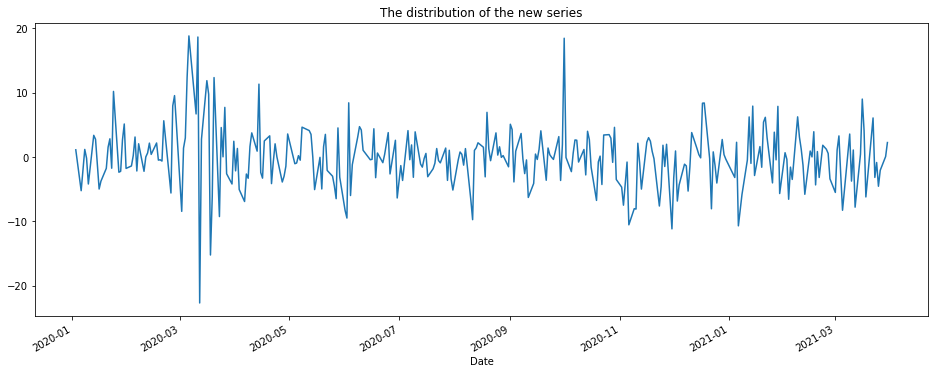

In [26]:
#plot the new series
plt.figure(figsize=(16,6))
plt.title("The distribution of the new series")
df_russia['diff_1'].plot()


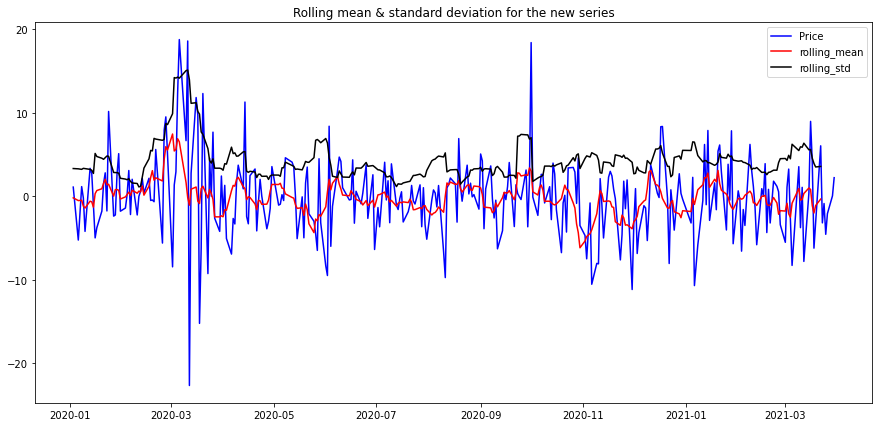

In [27]:
#plot rolling statistics
plt.figure(figsize=(15,7))
orig=plt.plot(df_russia.diff_1, color='blue',label='Price')
R_mean=plt.plot(df_russia.diff_1.rolling(7).mean(), color='red',label='rolling_mean')
R_std=plt.plot(df_russia.diff_1.rolling(7).std(), color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation for the new series')
plt.show(block='False')



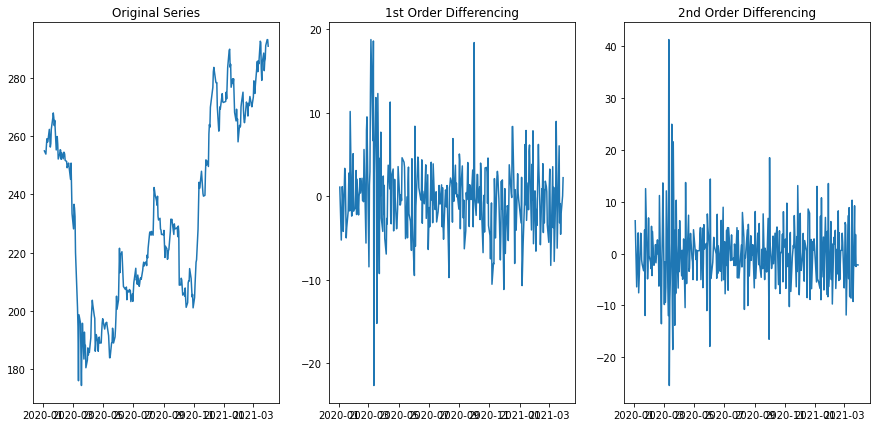

In [28]:
# Original Series
fig, axes = plt.subplots(1, 3, sharex=True,figsize=(15, 7))
axes[0].plot(df_russia.Price)
axes[0].set_title('Original Series')
#plot_acf(df1_russia.Price, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(df_russia.Price.diff())
axes[1].set_title('1st Order Differencing')
#plot_acf(df1_russia.Price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2].plot(df_russia.Price.diff().diff())
axes[2].set_title('2nd Order Differencing')
#plot_acf(df1_russia.Price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

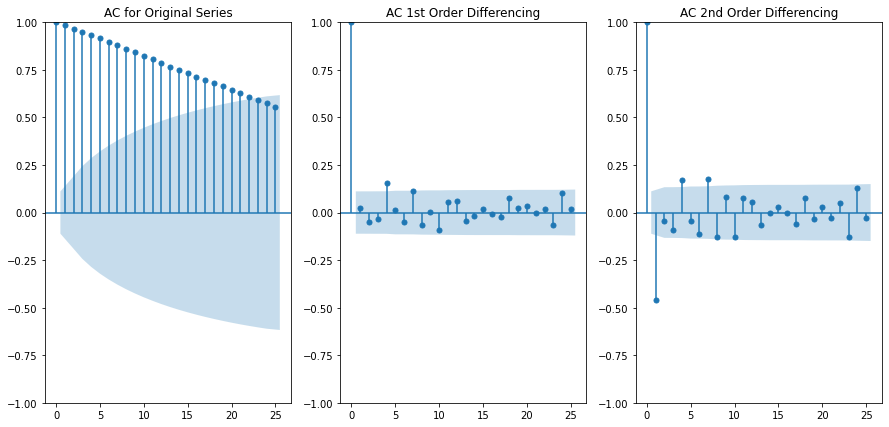

In [29]:
#Plot autocorrelation
# Original Series
fig, axes = plt.subplots(1, 3, sharex=True,figsize=(15, 7))
plot_acf(df_russia.Price, ax=axes[0])
axes[0].set_title('AC for Original Series')

# 1st Differencing
plot_acf(df_russia.Price.diff().dropna(), ax=axes[1])
axes[1].set_title('AC 1st Order Differencing')

# 2nd Differencing
plot_acf(df_russia.Price.diff().diff().dropna(), ax=axes[2])
axes[2].set_title('AC 2nd Order Differencing')

plt.show()

In [30]:
#d=1 ?
#How do we know if there is seasonality?
#how do we decide p,q?

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


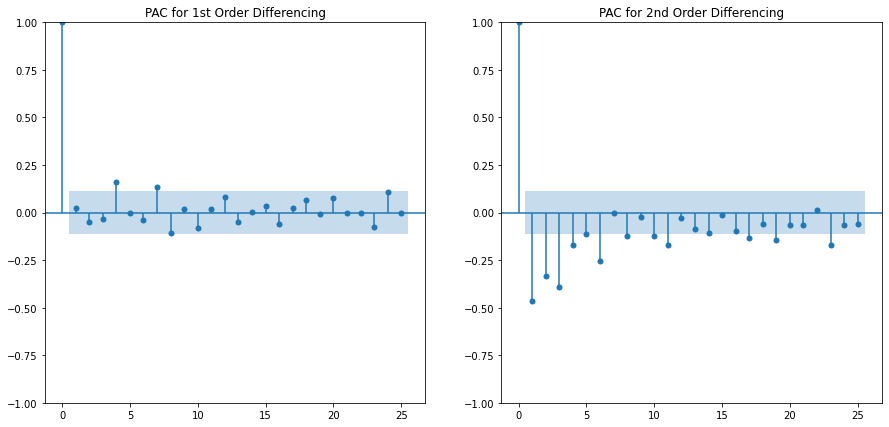

In [31]:
#Plot partial autocorrelation
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(15, 7))
# 1st Differencing
plot_pacf(df_russia.Price.diff().dropna(), ax=axes[0])
axes[0].set_title('PAC for 1st Order Differencing')

# 2nd Differencing
plot_pacf(df_russia.Price.diff().diff().dropna(), ax=axes[1])
axes[1].set_title('PAC for 2nd Order Differencing')

plt.show()

In [32]:
#split the data
train_rus = df_russia[df_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_rus = train_rus.dropna()
test_rus = df_russia[df_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_rus = test_rus.dropna()

In [33]:
train_rus.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2020-12-30,271.65,272.49,274.24,270.12,31.53,-0.0013,-0.35
2020-12-29,272.00,275.91,276.43,271.26,39.02,-0.0098,0.35
2020-12-28,274.70,270.90,275.19,269.73,39.04,0.0150,2.70
2020-12-25,270.64,269.97,271.00,268.28,11.99,0.0049,-4.06
2020-12-24,269.32,271.98,272.82,267.13,42.61,-0.0029,-1.32


In [34]:
test_rus.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56
2021-03-24,285.79,283.40,288.00,282.25,46.41,0.0113,-0.87


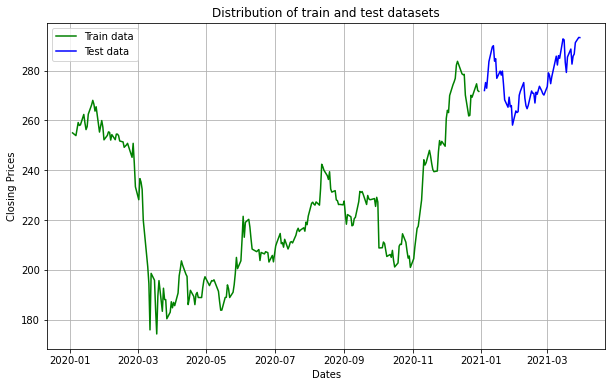

In [35]:
#plot the distribution of train and test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_rus.Price, 'green', label='Train data')
plt.plot(test_rus.Price, 'blue', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

In [36]:
arima_model = pm.auto_arima(train_rus['Price'], start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [37]:
y_pred = arima_model.predict(len(test_rus['Price']))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
test_rus['Pred'] = y_pred.values

In [39]:
test_rus.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Pred
Date,,,,,,,,
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23,255.859002
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05,255.786833
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08,254.947738
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56,255.777813
2021-03-24,285.79,283.40,288.00,282.25,46.41,0.0113,-0.87,255.194846


In [40]:
def actual_prediction_plot(actual, prediction):
    plt.figure(figsize=(16, 5))
    plt.plot(actual, label='Actual', linewidth=1.5)
    plt.plot(prediction, label='Predictions', linewidth=1.5)
    plt.title('Actual  VS. Predicted Price', fontsize=20)
    plt.legend();

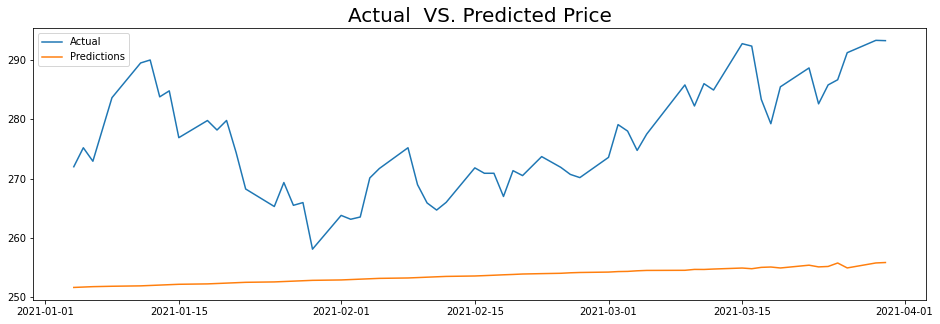

In [41]:
actual_prediction_plot(test_rus['Price'], test_rus['Pred'])

In [42]:
mse = mean_squared_error(test_rus['Price'], test_rus['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_rus['Price'], test_rus['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_rus['Price'], test_rus['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_rus['Pred'] - test_rus['Price'])/np.abs(test_rus['Price']))
print('MAPE: '+str(mape))

MSE: 597.5640545960573
MAE: 22.906011245812874
RMSE: 24.445123329532567
MAPE: 0.08192924635041844


In [43]:
#arimax


In [44]:
df1_russia=df_russia.copy()
df1_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,NaN
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56


In [45]:
df1_russia.reset_index(inplace=True)
df1_russia.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1
0,2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,NaN
1,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
4,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56


In [46]:
def add_exogenous_features(df):
    #df.reset_index(inplace=True)
    # the chosen columns
    
    lag_features = ['Open', 'High', 'Low', 'Volume', 'Change %']
    
    # choose the mean, std days
    window1 = 3
    window2 = 7
    window3 = 30
    
    # rolling
    df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
    df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
    df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
    
    # find the mean
    df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
    df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
    df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

    # fins the std
    df_std_3d = df_rolled_3d.std().shift(1).reset_index()
    df_std_7d = df_rolled_7d.std().shift(1).reset_index()
    df_std_30d = df_rolled_30d.std().shift(1).reset_index()

    # add the features to df
    for feature in lag_features:
        df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
        df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
        df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

        df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
        df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
        df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    
    # remove the nulls
    df.fillna(df.mean(), inplace=True)
    #df.set_index("Date", drop=False, inplace=True)
    
    # add the other features
    df["month"] = df.Date.dt.month
    df["week"] = df.Date.dt.week
    df["day"] = df.Date.dt.day
    df["day_of_week"] = df.Date.dt.dayofweek
    return df

In [47]:
df = add_exogenous_features(df1_russia)

<ipython-input-46-11eabc41eea8>:42: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)
<ipython-input-46-11eabc41eea8>:47: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


In [48]:
df1_russia.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
0,2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,-0.116194,234.476602,234.701885,...,0.000634,0.000610,0.000689,0.016982,0.018404,0.019890,3,13,31,2
1,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.230000,294.000000,294.000000,...,-0.007600,-0.007600,-0.007600,0.016982,0.018404,0.019890,3,13,30,1
2,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.050000,294.430000,294.430000,...,-0.003900,-0.003900,-0.003900,0.005233,0.005233,0.005233,3,13,29,0
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.080000,292.860000,292.860000,...,-0.000233,-0.000233,-0.000233,0.007350,0.007350,0.007350,3,12,26,4
4,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.560000,291.070000,291.802500,...,0.007600,0.003800,0.003800,0.008062,0.010054,0.010054,3,12,25,3


In [49]:
df1_russia.set_index("Date", drop=True, inplace=True)
df1_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,-0.116194,234.476602,234.701885,235.750501,...,0.000634,0.000610,0.000689,0.016982,0.018404,0.019890,3,13,31,2
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.230000,294.000000,294.000000,294.000000,...,-0.007600,-0.007600,-0.007600,0.016982,0.018404,0.019890,3,13,30,1
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.050000,294.430000,294.430000,294.430000,...,-0.003900,-0.003900,-0.003900,0.005233,0.005233,0.005233,3,13,29,0
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.080000,292.860000,292.860000,292.860000,...,-0.000233,-0.000233,-0.000233,0.007350,0.007350,0.007350,3,12,26,4
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.560000,291.070000,291.802500,291.802500,...,0.007600,0.003800,0.003800,0.008062,0.010054,0.010054,3,12,25,3


In [50]:
#select exogenous features
exogenous_features=df1_russia.columns[7:].values.tolist()
exogenous_features

['Open_mean_lag3',
 'Open_mean_lag7',
 'Open_mean_lag30',
 'Open_std_lag3',
 'Open_std_lag7',
 'Open_std_lag30',
 'High_mean_lag3',
 'High_mean_lag7',
 'High_mean_lag30',
 'High_std_lag3',
 'High_std_lag7',
 'High_std_lag30',
 'Low_mean_lag3',
 'Low_mean_lag7',
 'Low_mean_lag30',
 'Low_std_lag3',
 'Low_std_lag7',
 'Low_std_lag30',
 'Volume_mean_lag3',
 'Volume_mean_lag7',
 'Volume_mean_lag30',
 'Volume_std_lag3',
 'Volume_std_lag7',
 'Volume_std_lag30',
 'Change %_mean_lag3',
 'Change %_mean_lag7',
 'Change %_mean_lag30',
 'Change %_std_lag3',
 'Change %_std_lag7',
 'Change %_std_lag30',
 'month',
 'week',
 'day',
 'day_of_week']

In [51]:
#split data into train and test
train_ARMX = df1_russia[df1_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_ARMX=train_ARMX.dropna()
test_ARMX=df1_russia[df1_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_ARMX=test_ARMX.dropna()

In [52]:
print('shape of train set: ',train_ARMX.shape)
print('shape of test set: ',test_ARMX.shape)

shape of train set:  (250, 41)
shape of test set:  (61, 41)


In [53]:
arimax_model = pm.auto_arima(train_ARMX['Price'], exogenous=train_ARMX[exogenous_features], trace=False, error_action="ignore", 
                                 suppress_warnings=True)

In [54]:
arimax_model.fit(train_ARMX.Price, exogenous=train_ARMX[exogenous_features])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [55]:
# create the ARIMAX model
#model_ARMX = auto_arima(train_ARMX.Price, exogenous=train_ARMX[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)

In [56]:
#model_ARMX.fit(train_ARMX.Price, exogenous=train_ARMX[exogenous_features])

In [57]:
#get predicted prices
y_pred_ARMX = arimax_model.predict(n_periods=len(test_ARMX['Price']), exogenous=test_ARMX[exogenous_features])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [58]:
test_ARMX['Pred'] = y_pred_ARMX.values

In [59]:
test_ARMX.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week,Pred
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,-0.116194,234.476602,234.701885,235.750501,...,0.000610,0.000689,0.016982,0.018404,0.019890,3,13,31,2,255.0
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.230000,294.000000,294.000000,294.000000,...,-0.007600,-0.007600,0.016982,0.018404,0.019890,3,13,30,1,255.0
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.050000,294.430000,294.430000,294.430000,...,-0.003900,-0.003900,0.005233,0.005233,0.005233,3,13,29,0,255.0
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.080000,292.860000,292.860000,292.860000,...,-0.000233,-0.000233,0.007350,0.007350,0.007350,3,12,26,4,255.0
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.560000,291.070000,291.802500,291.802500,...,0.003800,0.003800,0.008062,0.010054,0.010054,3,12,25,3,255.0


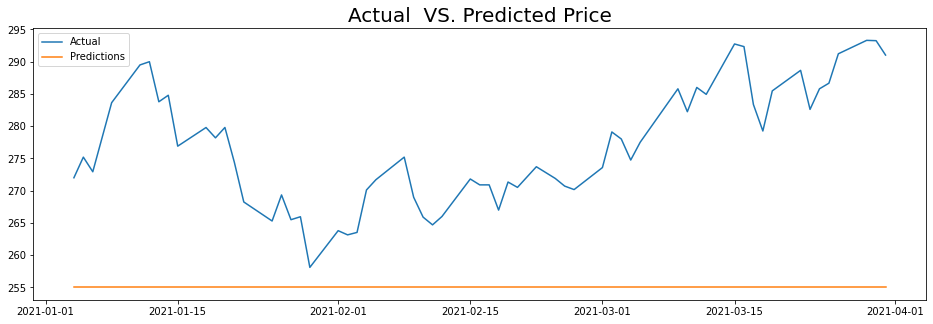

In [60]:
actual_prediction_plot(test_ARMX['Price'], test_ARMX['Pred'])

In [61]:
mse = mean_squared_error(test_ARMX['Price'], test_ARMX['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_ARMX['Price'], test_ARMX['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_ARMX['Price'], test_ARMX['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_ARMX['Pred'] - test_ARMX['Price'])/np.abs(test_ARMX['Price']))
print('MAPE: '+str(mape))

MSE: 556.6030426229509
MAE: 21.768852459016394
RMSE: 23.59243613158571
MAPE: 0.07766249860739152


In [62]:
# As we can see Arima and Arimax models are not the best models for this data

In [63]:
#FB Prophet

In [64]:
df2_russia=df_russia.copy()
#df2_russia.set_index("Date", drop=False, inplace=True)
df2_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,NaN
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56


In [65]:
train_pro = df2_russia[df2_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_pro=train_pro.dropna()
test_pro=df2_russia[df2_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_pro=test_pro.dropna()

In [66]:
train_pro.reset_index(drop=False, inplace=True)
train_pro.head()


,Date,Price,Open,High,Low,Volume,Change %,diff_1
0,2020-12-30,271.65,272.49,274.24,270.12,31.53,-0.0013,-0.35
1,2020-12-29,272.00,275.91,276.43,271.26,39.02,-0.0098,0.35
2,2020-12-28,274.70,270.90,275.19,269.73,39.04,0.0150,2.70
3,2020-12-25,270.64,269.97,271.00,268.28,11.99,0.0049,-4.06
4,2020-12-24,269.32,271.98,272.82,267.13,42.61,-0.0029,-1.32


In [67]:
train_pro = train_pro[["Date", "Price"]]
train_pro.rename(columns={"Date": "ds", "Price": "y"}, inplace=True)
#train_pro.set_index("ds", drop=True, inplace=True)
train_pro.head()

,ds,y
0,2020-12-30,271.65
1,2020-12-29,272.00
2,2020-12-28,274.70
3,2020-12-25,270.64
4,2020-12-24,269.32


In [68]:
test_pro.reset_index(drop=False, inplace=True)
test_pro.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1
0,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
1,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
3,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56
4,2021-03-24,285.79,283.40,288.00,282.25,46.41,0.0113,-0.87


In [69]:
test_pro = test_pro[["Date", "Price"]]
test_pro.rename(columns={"Date": "ds", "Price": "y"}, inplace=True)
#test_pro.set_index("ds", drop=True, inplace=True)
test_pro.head()

,ds,y
0,2021-03-30,293.25
1,2021-03-29,293.30
2,2021-03-26,291.22
3,2021-03-25,286.66
4,2021-03-24,285.79


In [70]:
model = Prophet().fit(train_pro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [71]:
forecast = model.predict(test_pro[['ds']])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [72]:
mae_pro = mean_absolute_error(test_pro.y, forecast.yhat)
mae_pro

46.45075062200292

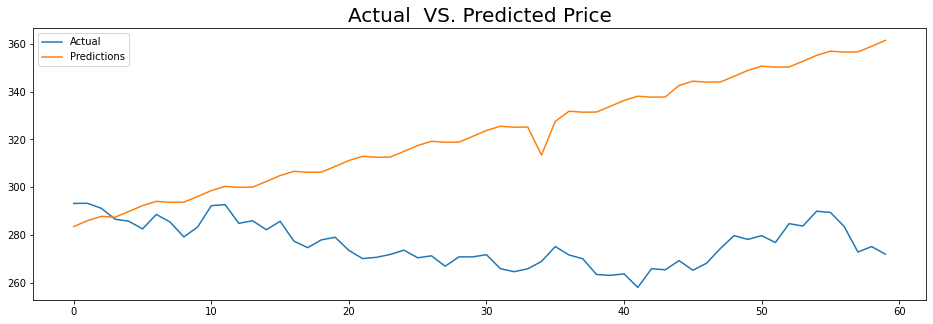

In [73]:
actual_prediction_plot(test_pro.y, forecast.yhat)

In [74]:
#Bollinger Bands

In [75]:
#Turkey dataset

In [76]:
#xls = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')
#df_russia = pd.read_excel(xls, 'Russia - Sberbank Rossii PAO (S')
df_turkey = pd.read_excel(xls, 'Turkey - Koc Holding AS (KCHOL)')

In [77]:
df_turkey.shape

(316, 7)

In [78]:
df_turkey.tail()

,Date,Price,Open,High,Low,Vol.,Change %
311,2020-01-07 00:00:00,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06 00:00:00,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03 00:00:00,20.3,20.3,20.44,19.97,3.31M,-0.0039
314,2020-01-02 00:00:00,20.38,20.42,20.44,20.24,2.53M,0.0030
315,Highest: 25.48,Lowest: 12.38,Difference: 13.10,Average: 17.86,Change %: -4.48,NaN,NaN


In [79]:
#Rename the Vol. column to Volume
df_turkey.rename(columns = {'Vol.': 'Volume'}, inplace = True)

In [80]:
#drop the last row
df_turkey.drop(index=df_turkey.index[-1], axis=0, inplace=True)
df_turkey["Volume"]=df_turkey.Volume.str.replace('M','')

In [81]:
df_turkey["Date"]=pd.to_datetime(df_turkey.Date,format="%Y-%m-%d")

In [82]:
df_turkey=df_turkey.astype({'Price':'float','Open':'float','High':'float','Low':'float','Volume':'float'})
print(df_turkey.dtypes)

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Volume             float64
Change %           float64
dtype: object


In [83]:
df_turkey.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

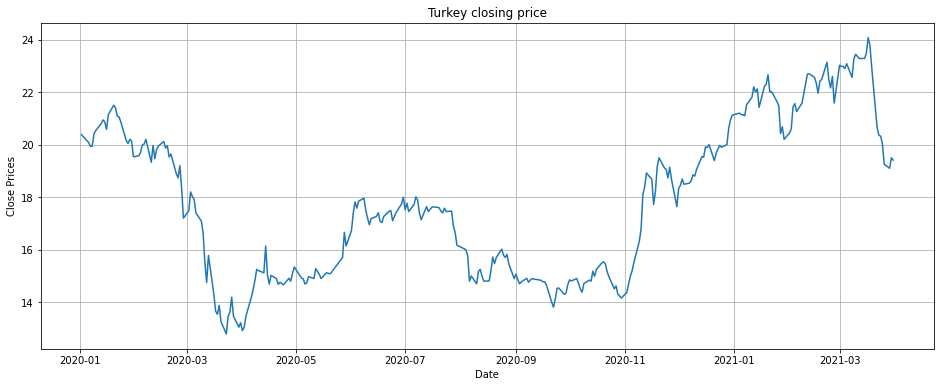

In [84]:
plt.figure(figsize=(16,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_turkey['Date'],df_turkey['Price'])
plt.title('Turkey closing price')
plt.show()

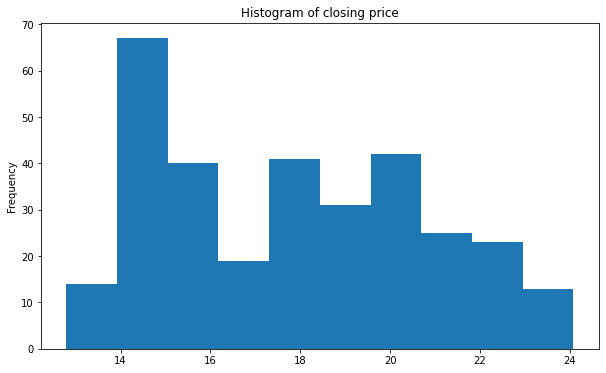

In [85]:
plt.figure(figsize=(10,6))
df_close_turk = df_turkey['Price']
df_close_turk.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

In [86]:
df_turkey.set_index("Date", inplace = True)
df_turkey.head()

,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148


rolling_mean: Date
2021-03-31          NaN
2021-03-30          NaN
2021-03-29          NaN
2021-03-26          NaN
2021-03-25          NaN
2021-03-24          NaN
2021-03-23    19.708571
2021-03-22    19.887143
2021-03-19    20.378571
Name: Price, dtype: float64 

rolling_std: Date
2021-03-31         NaN
2021-03-30         NaN
2021-03-29         NaN
2021-03-26         NaN
2021-03-25         NaN
2021-03-24         NaN
2021-03-23    0.517765
2021-03-22    0.605715
2021-03-19    1.270229
Name: Price, dtype: float64


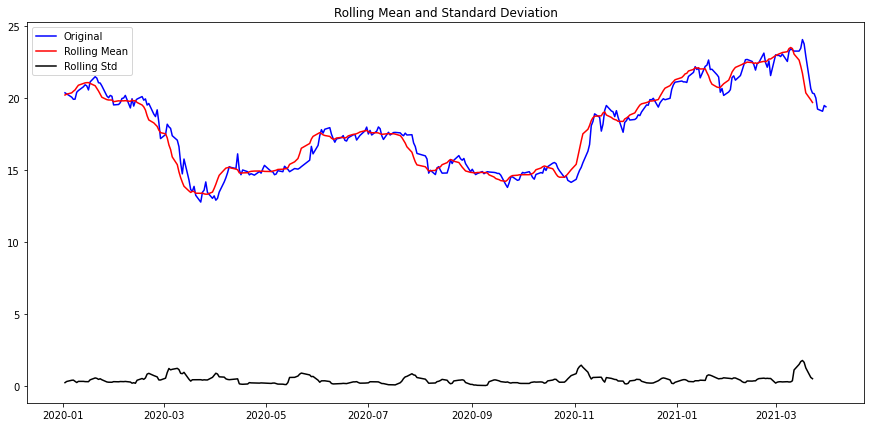

Results of dickey fuller test
Test Statistics                 -1.227784
p-value                          0.661531
No. of lags used                 0.000000
Number of observations used    314.000000
critical value (1%)             -3.451349
critical value (5%)             -2.870789
critical value (10%)            -2.571698
dtype: float64


In [87]:
test_stationarity(df_turkey['Price'])

In [88]:
#We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis - that the time series is non-stationary and does have time-dependent structure. Also, the test statistics is greater than the critical values. so the data is non-stationary and does have time-dependent structure.

In [89]:
df_turkey["diff_1"] = df_turkey.Price.diff(periods=1)
df_turkey.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046,NaN
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209,0.09
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078,-0.40
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385,0.15
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148,0.77


In [90]:
results_turk = adfuller(df_turkey["diff_1"].dropna())
print('The new p-value is:',results[1])

The new p-value is: 4.3951775754216564e-07


<AxesSubplot:title={'center':'The distribution of the new series'}, xlabel='Date'>

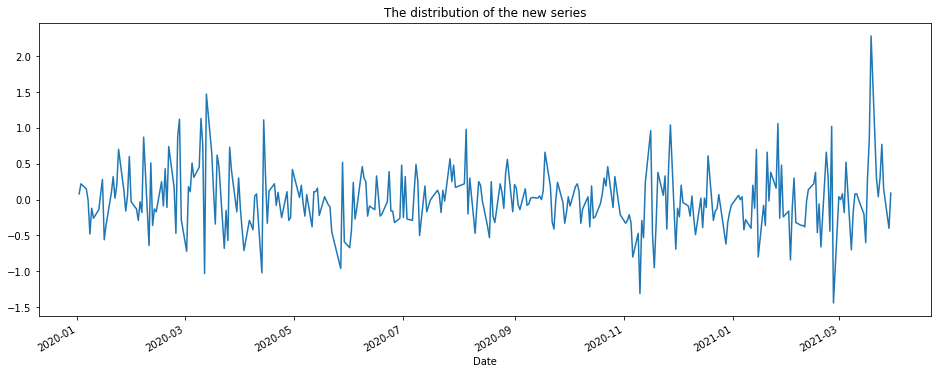

In [91]:
#plot the new series
plt.figure(figsize=(16,6))
plt.title("The distribution of the new series")
df_turkey['diff_1'].plot()

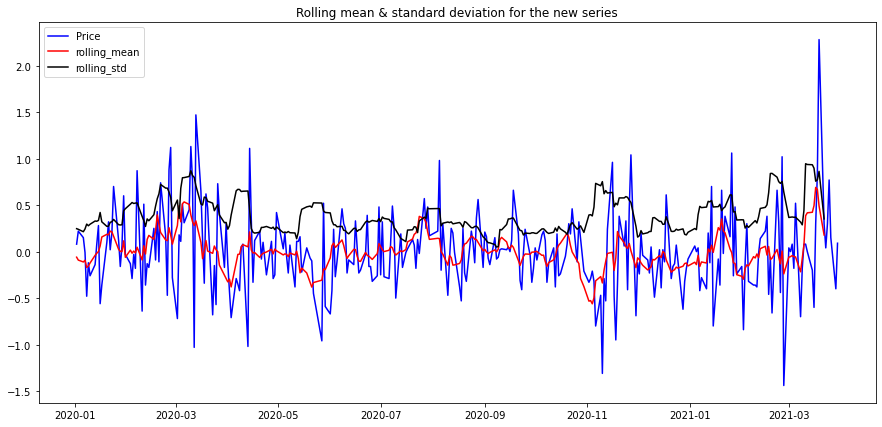

In [92]:
#plot rolling statistics
plt.figure(figsize=(15,7))
orig=plt.plot(df_turkey.diff_1, color='blue',label='Price')
R_mean=plt.plot(df_turkey.diff_1.rolling(7).mean(), color='red',label='rolling_mean')
R_std=plt.plot(df_turkey.diff_1.rolling(7).std(), color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation for the new series')
plt.show(block='False')


In [93]:
#split the data
train_turk = df_turkey[df_turkey.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_turk=train_turk.dropna()
test_turk=df_turkey[df_turkey.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_turk=test_turk.dropna()

In [94]:
arima_model_turk = pm.auto_arima(train_turk['Price'], start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [95]:
y_pred_turk = arima_model_turk.predict(len(test_turk['Price']))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [96]:
test_turk['Pred'] = y_pred_turk.values

In [97]:
test_turk.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Pred
Date,,,,,,,,
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209,0.09,20.349874
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078,-0.40,20.317496
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385,0.15,20.297859
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148,0.77,20.294592
2021-03-24,20.32,20.54,21.00,20.16,20.42,-0.0020,0.30,20.305747


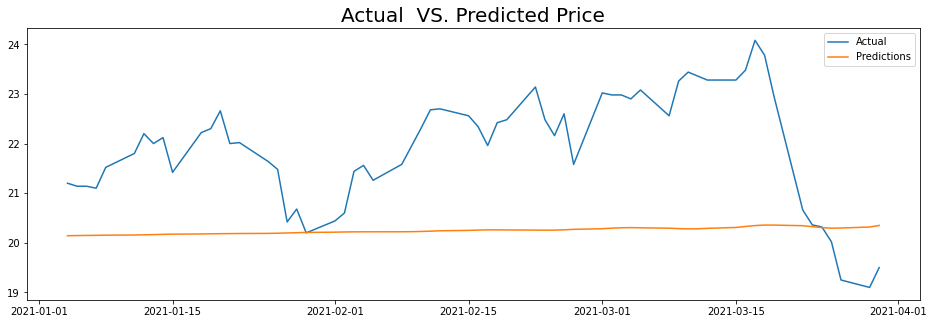

In [98]:
actual_prediction_plot(test_turk['Price'], test_turk['Pred'])

In [99]:
mse = mean_squared_error(test_turk['Price'], test_turk['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_turk['Price'], test_turk['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_turk['Price'], test_turk['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_turk['Pred'] - test_turk['Price'])/np.abs(test_turk['Price']))
print('MAPE: '+str(mape))

MSE: 4.065761975331719
MAE: 1.786268173124133
RMSE: 2.016373471193201
MAPE: 0.07964218366606342


In [100]:
#arimax

In [101]:
df1_turkey=df_turkey.copy()
df1_turkey.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046,NaN
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209,0.09
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078,-0.40
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385,0.15
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148,0.77


In [102]:
df1_turkey.reset_index(inplace=True)
df1_turkey.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1
0,2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046,NaN
1,2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209,0.09
2,2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078,-0.40
3,2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385,0.15
4,2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148,0.77


In [103]:
df1 = add_exogenous_features(df1_turkey)

<ipython-input-46-11eabc41eea8>:42: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)
<ipython-input-46-11eabc41eea8>:47: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


In [104]:
df1_turkey.set_index("Date", drop=True, inplace=True)
df1_turkey.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046,0.003089,17.868301,17.863453,17.873102,...,0.000159,0.000153,-0.000276,0.019451,0.021469,0.023521,3,13,31,2
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209,0.090000,19.420000,19.420000,19.420000,...,-0.004600,-0.004600,-0.004600,0.019451,0.021469,0.023521,3,13,30,1
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078,-0.400000,19.270000,19.270000,19.270000,...,0.008150,0.008150,0.008150,0.018031,0.018031,0.018031,3,13,29,0
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385,0.150000,19.260000,19.260000,19.260000,...,0.002833,0.002833,0.002833,0.015728,0.015728,0.015728,3,12,26,4
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148,0.770000,19.546667,19.515000,19.515000,...,-0.008467,-0.007500,-0.007500,0.029706,0.024331,0.024331,3,12,25,3


In [105]:
#select exogenous features
exogenous_features_turk=df1_turkey.columns[7:].values.tolist()
exogenous_features_turk

['Open_mean_lag3',
 'Open_mean_lag7',
 'Open_mean_lag30',
 'Open_std_lag3',
 'Open_std_lag7',
 'Open_std_lag30',
 'High_mean_lag3',
 'High_mean_lag7',
 'High_mean_lag30',
 'High_std_lag3',
 'High_std_lag7',
 'High_std_lag30',
 'Low_mean_lag3',
 'Low_mean_lag7',
 'Low_mean_lag30',
 'Low_std_lag3',
 'Low_std_lag7',
 'Low_std_lag30',
 'Volume_mean_lag3',
 'Volume_mean_lag7',
 'Volume_mean_lag30',
 'Volume_std_lag3',
 'Volume_std_lag7',
 'Volume_std_lag30',
 'Change %_mean_lag3',
 'Change %_mean_lag7',
 'Change %_mean_lag30',
 'Change %_std_lag3',
 'Change %_std_lag7',
 'Change %_std_lag30',
 'month',
 'week',
 'day',
 'day_of_week']

In [106]:
#split data into train and test
train_ARMX_turk = df1_turkey[df1_turkey.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_ARMX_turk = train_ARMX_turk.dropna()
test_ARMX_turk =df1_turkey[df1_turkey.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_ARMX_turk =test_ARMX_turk.dropna()

In [107]:
print('shape of train set: ',train_ARMX_turk.shape)
print('shape of test set: ',test_ARMX_turk.shape)

shape of train set:  (252, 41)
shape of test set:  (63, 41)


In [108]:
arimax_model_turk = pm.auto_arima(train_ARMX_turk['Price'], exogenous=train_ARMX_turk[exogenous_features_turk], trace=False, error_action="ignore", 
                                 suppress_warnings=True)

In [109]:
arimax_model_turk.fit(train_ARMX_turk.Price, exogenous=train_ARMX_turk[exogenous_features_turk])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [110]:
#get predicted prices
y_pred_ARMX_turk = arimax_model_turk.predict(n_periods=len(test_ARMX_turk['Price']), exogenous=test_ARMX_turk[exogenous_features_turk])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [111]:
test_ARMX_turk['Pred'] = y_pred_ARMX_turk.values

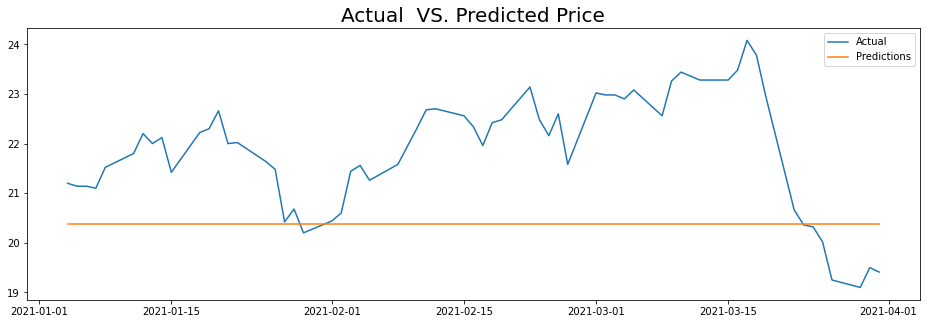

In [112]:
actual_prediction_plot(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])

In [113]:
mse = mean_squared_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_ARMX_turk['Pred'] - test_ARMX_turk['Price'])/np.abs(test_ARMX_turk['Price']))
print('MAPE: '+str(mape))

MSE: 3.6113047619047656
MAE: 1.656190476190477
RMSE: 1.9003433273765995
MAPE: 0.07386536284170112


In [ ]:
#Prophet

In [ ]:
#Bollinger Bands